Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


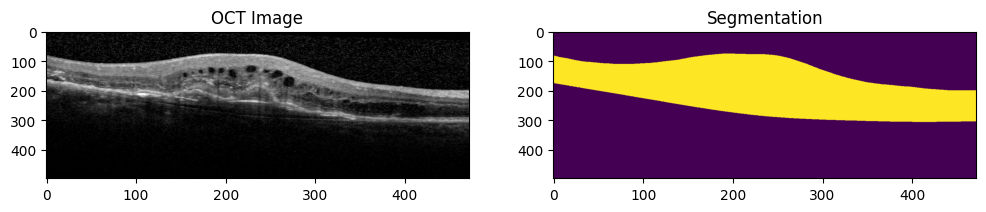

In [24]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

img = mpimg.imread('/content/drive/My Drive/oct.png')
segm = mpimg.imread('/content/drive/My Drive/oct_segm.png').astype(bool)

fig, ax = plt.subplots(1, 2, figsize=(12, 3))
ax[0].imshow(img, cmap='gray', aspect=0.33)
ax[0].title.set_text('OCT Image')
ax[1].imshow(segm, aspect=0.33)
ax[1].title.set_text('Segmentation')
plt.show()

# Praktische Übung 1
## Aufgabe 2: Einführung Bildverarbeitung
Diese Aufgabe soll Ihnen einen Einstieg in die Verarbeitung von digitalen Bildern ermöglichen. Um die To-Dos bearbeiten zu können, speichern Sie bitte eine Kopie dieses Notebooks in Ihrem Drive-Ordner und laden Sie außerdem die im Moodle zur Verfügung gestellten Bilder in Ihren Drive-Ordner hoch. Auch die Abgabe des fertig bearbeiteten Notebooks erfolgt über Moodle.


## Segmentierung und Dice-Score
Die altersbedingte Makuladegeneration ist die häufigste Erblindungsursache in der westlichen Welt. Ein wichtiger Biomarker zur Bemessung des Fortschreitens der Erkrankung ist das Retinavolumen. Ziel dieser Aufgabe ist der Erstellung eines automatischen Tools zur Berechnung des Retinavolumens anhand von Aufnahmen der optischen Kohärenztomographie (engl. optical coherence tomography (OCT))![Unbenannt.png](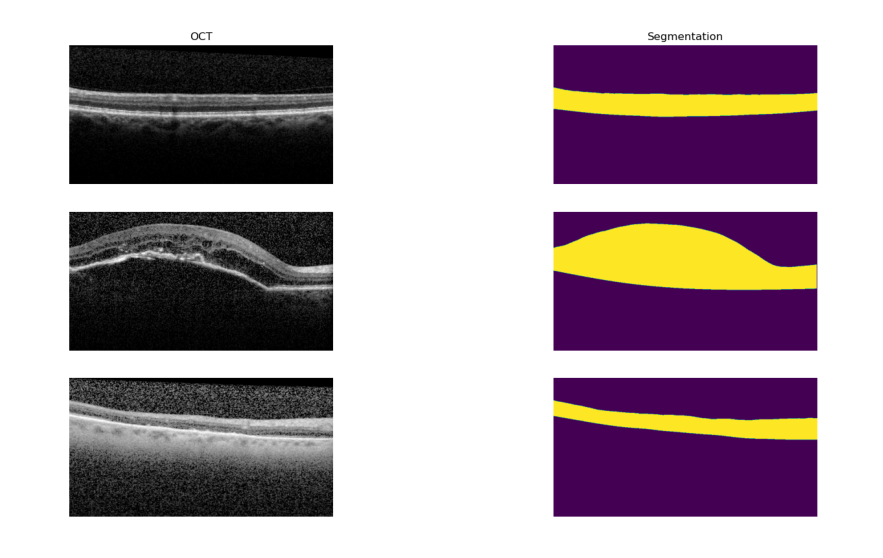![Unbenannt.png](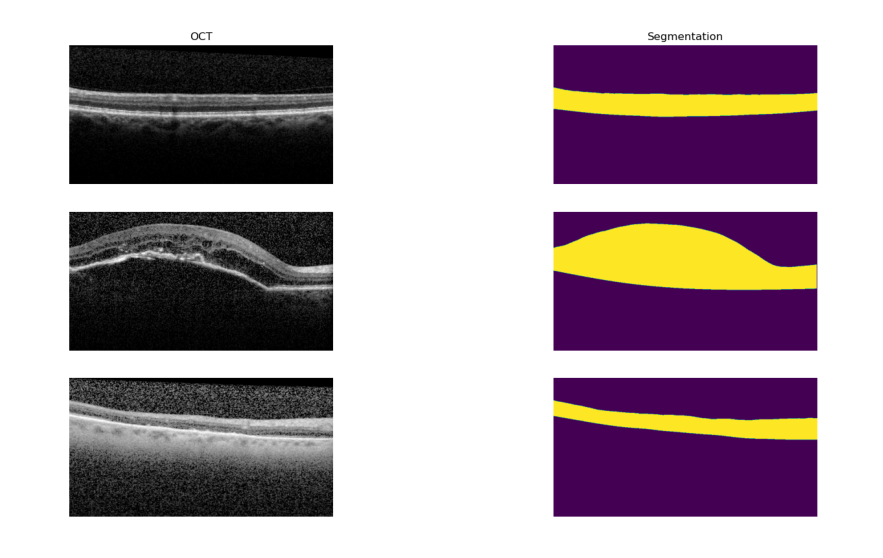![Unbenannt.png](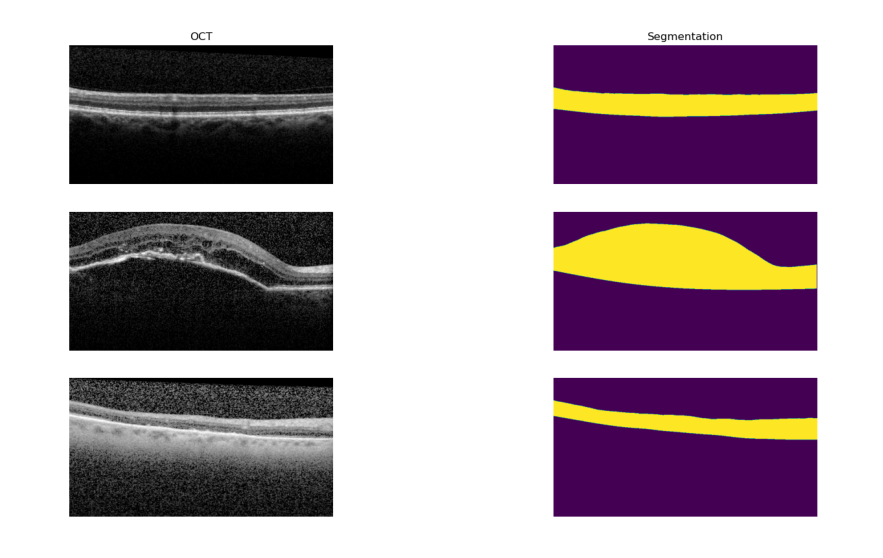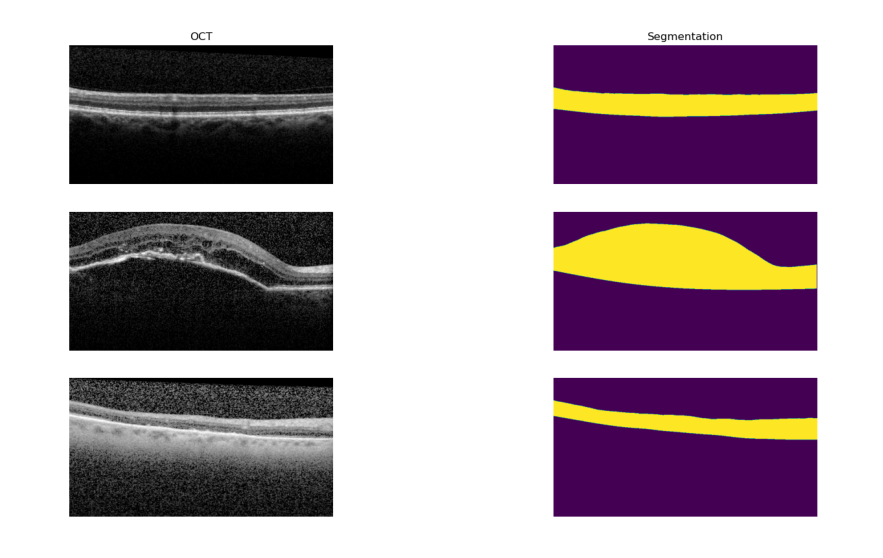))). Ein Arzt hat Ihnen dafür beispielhafte Bilder mit manuell erstellten Segmentierungen zur Verfügung gestellt (siehe unten).


Die Retina erscheint in den OCT-Aufnahmen wesentlich heller als der Hintergrund. Sie entscheiden sich daher eine erste Segmentierung mittels Thresholding zu erstellen.

## To Do 1
Erstellen Sie ein binäres Bild aus dem Original-OCT-Bild, in dem Sie das Schwellenwertverfahren anwenden. Plotten Sie das Ergebnis

Hinweis: Die Bildintensitäten liegen im Bereich \[0, 1\].

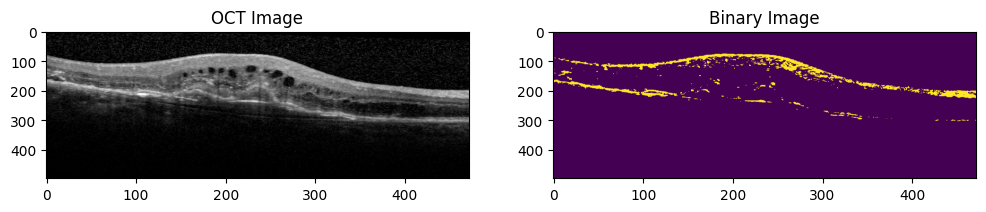

In [33]:
binary = img > 0.5

fig, ax = plt.subplots(1, 2, figsize=(12, 3))
ax[0].imshow(img, cmap='gray', aspect=0.33)
ax[0].title.set_text('OCT Image')
ax[1].imshow(binary, aspect=0.33)
ax[1].title.set_text('Binary Image')
plt.show()

Der Dice-Score ist eine Metrik zur Bewertung der Segmentierungsgenauigkeit. Dabei wird eine Segmentierung mit der Grundwahrheit (manuelle Segmentierung) verglichen. Eine informelle Definition des Dice-Scores ist gegeben durch

$DICE = \frac{2\cdot \mathrm{Intersection}}{\mathrm{Union + Intersection}}=\frac{2TP}{2TP+FN+FP}$.

Für weitere Informationen: https://towardsdatascience.com/how-accurate-is-image-segmentation-dd448f896388.


## To Do 2
Berechnen Sie den Dice-Score zwischen der manuellen Segmentierung und der Segmentierung, die aus dem Schwellenwertverfahren resultiert.




In [34]:
def dice(pred, target):
    intersection = np.logical_and(pred, target).sum()
    return 2 * intersection / (pred.sum() + target.sum())

dice_score = dice(binary, segm)
print("DICE-Score für threshold=0.5:", dice_score)

DICE-Score für threshold=0.5: 0.2170948577200654


## To Do 3
Testen Sie verschiedene Schwellenwerte für die Generierung der Segmentierung. Versuchen Sie, einen möglichst hohen Dice-Score zu erreichen (Sie sollten einen Dice von mind. 80% erreichen). Plotten Sie Ihr bestes Ergebnis und geben Sie den zugehörigen Dice-Score aus.

Bester Threshold: 0.200
Höchster DICE-Score: 0.8614


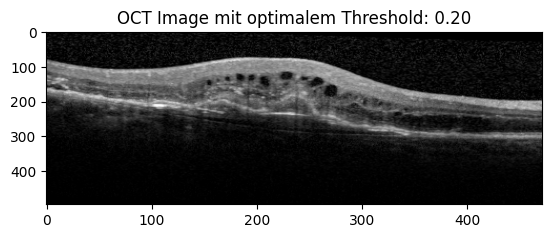

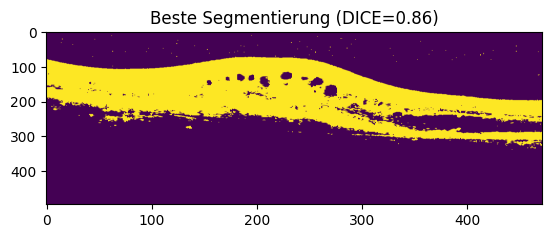

In [35]:
best_score = 0
best_thresh = 0

for t in np.linspace(0.2, 0.8, 100):
    auto_segm = img > t
    score = dice(auto_segm, segm)
    if score > best_score:
        best_score = score
        best_thresh = t

print(f"Bester Threshold: {best_thresh:.3f}")
print(f"Höchster DICE-Score: {best_score:.4f}")

# Visualisiere beste Segmentierung
plt.imshow(img, cmap='gray', aspect=0.33)
plt.title(f'OCT Image mit optimalem Threshold: {best_thresh:.2f}')
plt.figure()
plt.imshow(img > best_thresh, aspect=0.33)
plt.title(f'Beste Segmentierung (DICE={best_score:.2f})')
plt.show()


## To Do 4
Die intraretinalen Fluide (schwarze Punkte innerhalb der Retina) werden durch das Schwellenwertverfahren dem Hintergrund zugeordnet. Gleichzeitig kann es passieren, dass durch das Rauschen im Bild einzelne Hintergrundpixel der Segmentierung zugeordnet werden. Versuchen Sie, den Dice-Score zu verbessern, in dem Sie die Löcher in der Segmentierung schließen/verkleinern und sehr kleine segmentierte Bereiche entfernen.

Hinweis: `scipy.ndimage.morphology`

DICE-Score nach Morphologie: 0.8832


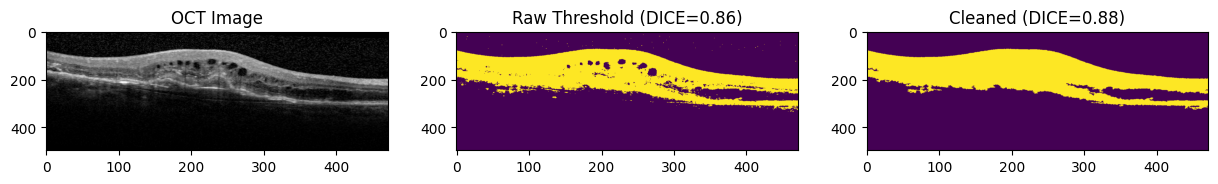

In [6]:
from scipy.ndimage import binary_fill_holes
from skimage.morphology import remove_small_objects

# Basierend auf optimalem Threshold
optimal_thresh = 0.2
initial = img > optimal_thresh

# Löcher in der Retina schließen
filled = binary_fill_holes(initial)

# Rauschen entfernen
cleaned = remove_small_objects(filled, min_size=200)

# Neue Bewertung
cleaned_dice = dice(cleaned, segm)
print(f"DICE-Score nach Morphologie: {cleaned_dice:.4f}")

# Plot Vergleich
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].imshow(img, cmap='gray', aspect=0.33)
ax[0].set_title('OCT Image')
ax[1].imshow(initial, aspect=0.33)
ax[1].set_title(f'Raw Threshold (DICE={best_score:.2f})')
ax[2].imshow(cleaned, aspect=0.33)
ax[2].set_title(f'Cleaned (DICE={cleaned_dice:.2f})')
plt.show()


## To Do 5
Berechnen Sie das Volumen der Retina in Kubikmillimetern für Ihre und die manuelle Segmentierung. Vergleichen Sie die Ergebnisse.

Hinweis: Das OCT-Gerät scannt einen 6mm x 6mm großen Bereich rund um die Fovea (Sehgrube) bei einer Eindringtiefe von 2mm. Jedes 3D OCT-Volumen besteht aus 25 2D Schichten (Eine dieser Schichten haben Sie in den vorangegangenen Aufgaben untersucht.).

In [7]:
# Größe eines Voxels in mm
voxel_width = 6 / img.shape[1]   # Breite pro Pixel
voxel_height = 2 / img.shape[0]  # Höhe pro Pixel
voxel_depth = 6 / 25             # Tiefe

voxel_volume = voxel_width * voxel_height * voxel_depth

# Segmentierungen: die berechnete vs manuell
vol_auto = cleaned.sum() * voxel_volume
vol_segm = segm.sum() * voxel_volume

print(f"Volumen aus userer Segmentierung: {vol_auto:.3f} mm³")
print(f"Volumen aus manueller Segmentierung: {vol_segm:.3f} mm³")

Volumen aus deiner Segmentierung: 0.736 mm³
Volumen aus manueller Segmentierung: 0.825 mm³


## To Do 6
Schauen Sie sich die folgenden OCT-Bilder an. Würde der von Ihnen entwickelte Segmentierungsalgorithmus auch für diese Bilder funktionieren? Begründen Sie Ihre Antwort.



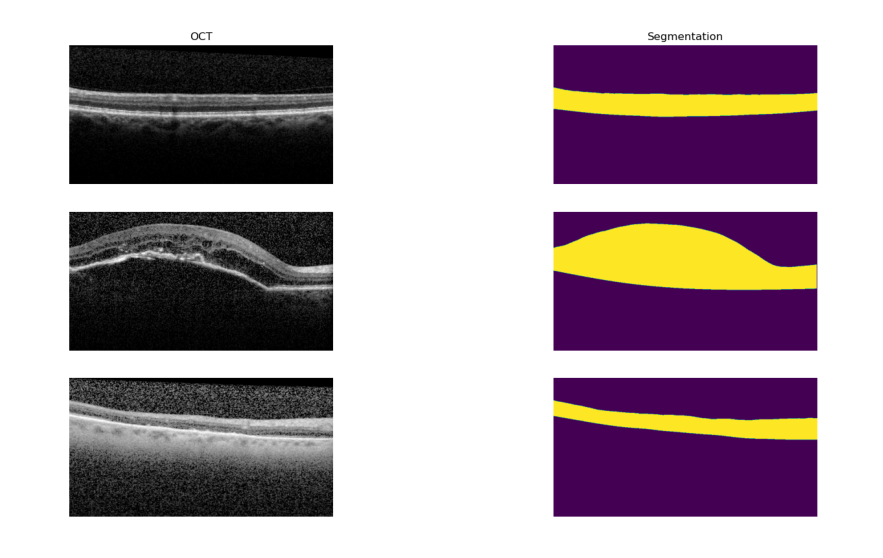

Antwort: Bei Bild 1 (oben) funktioniert die Methode sehr gut: Die Retina ist klar abgegrenzt, gleichmäßig hell und ohne auffällige Störungen – eine Segmentierung wäre hier zuverlässig. In Bild 2 (Mitte) treten intraretinale Flüssigkeiten auf, die im OCT-Bild als dunkle Flecken erscheinen. Diese werden vom Algorithmus als Hintergrund erkannt und führen zu einer fehlerhaften Segmentierung. Bild 3 (unten) zeigt starke Helligkeitsschwankungen und Rauschen. Dadurch können nicht-retinale Bereiche versehentlich segmentiert werden. Insgesamt ist der Algorithmus für standardisierte, gesunde OCT-Bilder geeignet, zeigt jedoch Schwächen bei pathologischen oder verrauschten Daten.

## Datenaugmentierung
Ein anderes Verfahren zur Segmentierung der OCT-Aufnahmen könnte das Training eines neuronalen Faltungsnetzwerkes sein. Insbesondere im medizinischen Kontext liegen oft nur wenige Datensätze vor. Wir werden daher in dieser Aufgabe einigen Datenaugmentierungstechniken implementieren.

Als Testbild dient ``cameraman``.

## To Do 1
Ergänzen Sie die ``Image``-Klasse um die folgenden Funktionen:

*   `normalize(self, min_value=0, max_value=255)` - Diese Funktion soll die Bildintensitäten linear auf das Intervall `[min_value, max_value]`. Ihre Implementierung sollte unabhängig vom Eingangsintensitätsbereich funktionieren.
*   `flip(self)` - Diese Funktion soll das Bild horizontal spiegeln.
*   `shift(self, amount=10)` - Diese Funktion soll das Bild um `amount` Picel vertikal (nach oben) verschieben. Dabei darf sich die Bildgröße **nicht** verändern.
*   `center_crop(self, new_size=[20, 20])` - Diese Funktion soll das Bild symmetrisch um die Mitte herum zuschneiden, so dass die neue Größe `new_size` ist.

Vergessen Sie nicht, die Klassenvariablen anzupassen, falls nötig!

## To Do 2
Wenden Sie Ihre neu implementierten Funktionen nacheinander auf das Bild an und plotten Sie Ihre Ergebnisse.


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import imutils
from skimage import data

class Image:
    def __init__(self, matrix):
        self.matrix = matrix
        self.size = matrix.shape
        self.max_value = np.max(matrix)
        self.min_value = np.min(matrix)

    def normalize(self, min_value=0, max_value=255):
        norm = (self.matrix - self.min_value) / (self.max_value - self.min_value)
        self.matrix = norm * (max_value - min_value) + min_value
        self.__init__(self.matrix)

    def flip(self):
        self.matrix = np.fliplr(self.matrix)
        self.__init__(self.matrix)

    def shift(self, amount=10):
        self.matrix = np.roll(self.matrix, -amount, axis=0)
        self.__init__(self.matrix)

    def center_crop(self, new_size=[20, 20]):
        h, w = self.matrix.shape
        ch, cw = new_size
        start_h = (h - ch) // 2
        start_w = (w - cw) // 2
        self.matrix = self.matrix[start_h:start_h+ch, start_w:start_w+cw]
        self.__init__(self.matrix)


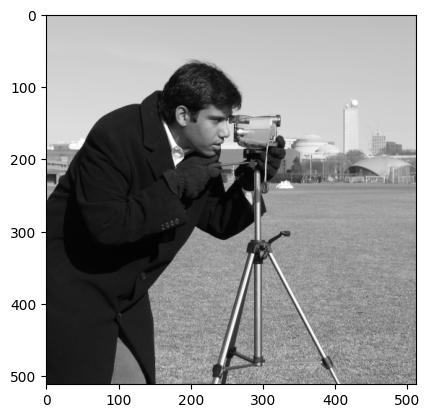

In [16]:
# Load and plot test image
from skimage import data
if __name__ == "__main__":
  im_matrix = data.camera()
  plt.imshow(im_matrix, cmap='gray');

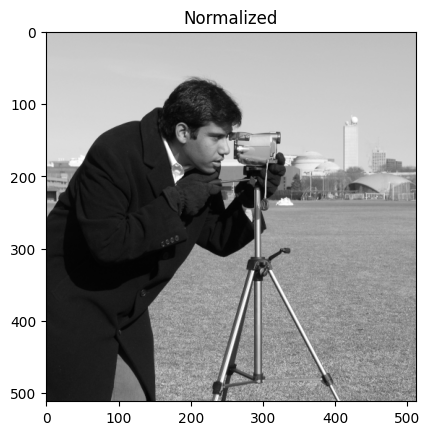

In [22]:
im = Image(im_matrix)
im.normalize() # Normalize image intensities

plt.imshow(im.matrix, cmap='gray')
plt.title("Normalized")
plt.axis('on')
plt.show()

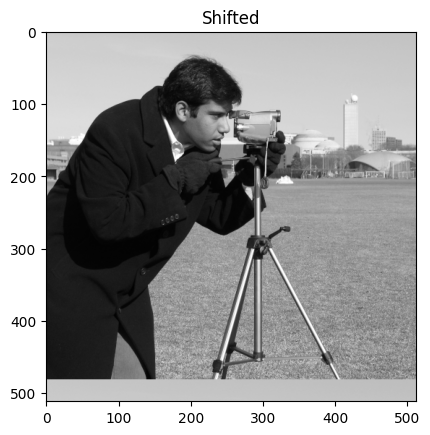

In [23]:
# Shift image
im.shift(30)

plt.imshow(im.matrix, cmap='gray')
plt.title("Shifted")
plt.axis('on')
plt.show()

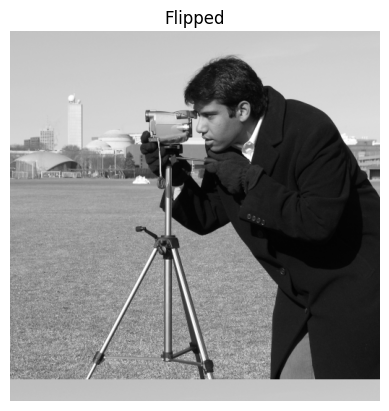

In [19]:
# Flip image
im.flip()
plt.imshow(im.matrix, cmap='gray')
plt.title("Flipped")
plt.axis('on')
plt.show()

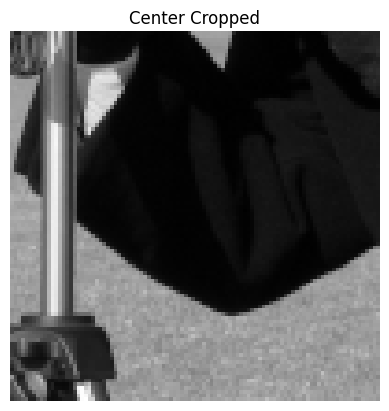

In [20]:
# To do: Center crop image
im.center_crop([100, 100])
plt.imshow(im.matrix, cmap='gray')
plt.title("Center Cropped")
plt.axis('on')
plt.show()
